# 

# 1. 多文件處理
當只有一個文件時可以直接放進 prompt 裡，但當面對複數或不特定數量的文件 (Document) 我們可以怎麼處理? 

如果把所有的文件加起來會太長，超過模型可處理長度怎麼辦？

常見的情境包括: 客服機器人針對某個問題抽取到多個相關的文章、對多篇新聞進行摘要等等。

Langchain 提供了四種現成的處理方法
- **Stuff**: 全部文件 (document) 的文字接在一起變成一大片文字
- **MapReduce**: 對每個文件 (document) 都單獨跑一次處理，再將得到的結果合併一起跑處理。 
- **Refine**: 對第一個文件 (document) 跑第一次處理得到第一個結果，再利用下一個文件嘗試修改結果，以此類推直到看過最後一個文件，得到最終的結果。
- **MapRerank**: 對每個文件 (document) 跑一次處理，得到結果和分數，選擇分數最高的結果作為最終結果。

## 1.1 Stuff
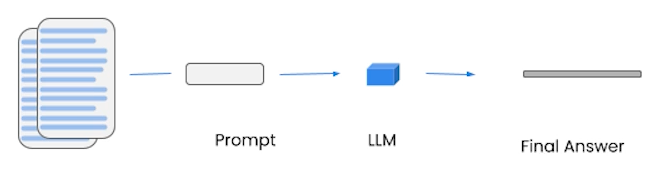

把所有文件 (document) 的內容串接起來變成一個內容 (context)

In [1]:
from operator import itemgetter
from langchain.schema import Document, format_document
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.chains import StuffDocumentsChain, LLMChain
from langchain_setup import ChatOpenAI, tracing_v2_enabled_if_api_key_set
from langchain.schema.runnable import RunnableLambda

documents = [
    Document(page_content="情況已經開始失控了", metadata={"a_custom_attribute": "複讀機"}),
    Document(page_content="月亮已經很紅了", metadata={"a_custom_attribute": "真美"}),
    Document(page_content="如果不想死的話就快逃吧", metadata={"a_custom_attribute": "好喔"}),
    Document(page_content="已經沒有時間了", metadata={"a_custom_attribute": "真假"}),
]

qa_prompt = ChatPromptTemplate.from_template(
    "請依據下列資訊回答問題:\n{context}\n\n問題: {question}"
)
model = ChatOpenAI()
qa_chain = LLMChain(prompt=qa_prompt, llm=model)

stuff_chain = StuffDocumentsChain(
    llm_chain=qa_chain,
    document_variable_name="context",
    input_key="input_documents",  # default
    output_key="output_text",  # default
    verbose=True,
)

In [2]:
with tracing_v2_enabled_if_api_key_set(project_name='tutorial'):
    response = stuff_chain(
        {
            "input_documents": documents,  # StuffDocumentsChain 的 `input_key`
            "question": "為什麼要逃？",  # prompt 中除 StuffDocumentsChain 的 `output_key` 以外的 `input_variables`
        },
    )
    print(response["output_text"])  # StuffDocumentsChain 的 output key



> Entering new StuffDocumentsChain chain...

> Finished chain.
[LangSmith URL]: https://smith.langchain.com/o/34ec837d-8405-462d-b949-fdfaebda792b/projects/p/fdcbda35-4d3a-418b-ab49-7e3205e630a6/r/ac03bc87-b64f-4309-81a1-5afc019f1876?poll=true
從資訊中可以推測出情況可能非常危險且隨時可能變得更糟，而且有可能造成生命危險。因此，逃跑可能是為了保命或避免受到傷害。


實際上的作法可以參考 Langchain Expression Language (LCEL) 的實作

In [2]:
DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")


def combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)


qa_inputs = {
    "context": itemgetter("input_documents") | RunnableLambda(combine_documents),
    "question": itemgetter("question"),
}
lcel_stuff_chain = qa_inputs | qa_prompt | model
lcel_stuff_chain.invoke({"input_documents": documents, "question": "為什麼要逃？"})

AIMessage(content='根據提供的資訊，情況已經開始失控且月亮已經很紅，並且說如果不想死的話就快逃。這暗示著可能發生了一個危險的事件或災難，逃走是為了保命。由於已經沒有時間了，逃走可能是唯一的選擇，以避免可能的傷害或死亡。')

我們可以自訂文件 (document) 如何被插入 (document_prompt)，和文件間的分隔 (separator)

In [3]:
customized_stuff_chain = StuffDocumentsChain(
    llm_chain=qa_chain,
    document_variable_name="context",  # 合併文件後的結果插入 llm_chain 的 prompt 中名為 'context' 的 placehodler
    input_key="input_documents",  # default
    output_key="output_text",  # default
    document_prompt=PromptTemplate.from_template(
        "文章內容： {page_content}\n其他屬性：{a_custom_attribute}"
    ),
    document_separator="\n-----\n",
    verbose=True,
)
response = customized_stuff_chain(
    {
        "input_documents": documents,  # StuffDocumentsChain 的 `input_key`
        "question": "為什麼要逃？",  # prompt 中除 StuffDocumentsChain 的 `output_key` 以外的 `input_variables`
    },
)
print(response["output_text"])  # StuffDocumentsChain 的 output key



> Entering new StuffDocumentsChain chain...

> Finished chain.
根據提供的資訊，無法確定為什麼要逃。


**想想看**: 如果文件很長或很多，對語言模型的閱讀理解或資訊抽取的能力會有影響嗎？

## 5.2. `MapReduceDocumentsChain`

In [1]:
from operator import itemgetter
from langchain.schema import Document, format_document
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.chains import MapReduceDocumentsChain, LLMChain, StuffDocumentsChain
from langchain.chains.summarize import load_summarize_chain

from langchain_setup import ChatOpenAI, tracing_v2_enabled_if_api_key_set


documents = [
    Document(page_content="我爸在夏威夷教我的", metadata={"a_custom_attribute": 1}),
    Document(page_content="每到夏天，我也是汗味戰士，大家都拜託我獨行。", metadata={"a_custom_attribute": 2}),
    Document(
        page_content="從以前混到現在，我唯一拿得起，放得下的只有筷子。", metadata={"a_custom_attribute": 3}
    ),
    Document(
        page_content="世界上99%的事可以靠錢解決，剩下的1%是需要更多錢。", metadata={"a_custom_attribute": 4}
    ),
]

fake_max_length = 100

stuffed_context = " ".join([doc.page_content for doc in documents])
len_stuffed_context = len(stuffed_context.split(" "))

print(
    f"將全部文件一併合起來的話，其長度 (token 數量) {len_stuffed_context} 會超過我們在這個例子裡假設的模型可處理的最長長度 (token 數量) {fake_max_length}"
)

將全部文件一併合起來的話，其長度 (token 數量) 4 會超過我們在這個例子裡假設的模型可處理的最長長度 (token 數量) 100


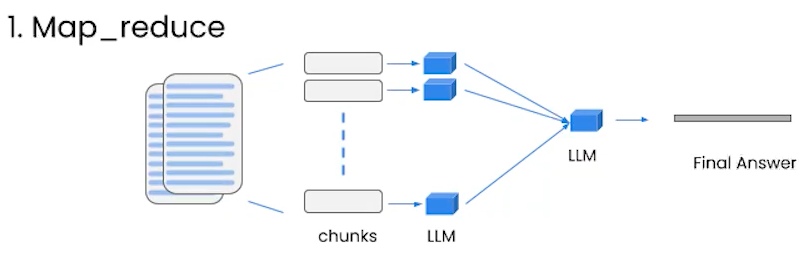

階層性地 (hierarchically) 且遞迴地 (recursively) 重複：[個別處理每個文件->將結果合併成數份不長於可處理長度的新文件] 

直到可以合併成只有一份新文件後，進行最終的處理產生最終的結果。

- 優點
    - 可以平行化處理
- 缺點
    - 呼叫 API 次數更多更花錢

In [2]:
map_reduce_summarize_chain = load_summarize_chain(
    llm=ChatOpenAI(), 
    chain_type="map_reduce", 
    token_max=fake_max_length, 
    verbose=True
)
with tracing_v2_enabled_if_api_key_set(project_name='tutorial'):
    final_summary = map_reduce_summarize_chain(documents)["output_text"]
    print(final_summary)



> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"我爸在夏威夷教我的"


CONCISE SUMMARY:
Prompt after formatting:
Write a concise summary of the following:


"每到夏天，我也是汗味戰士，大家都拜託我獨行。"


CONCISE SUMMARY:
Prompt after formatting:
Write a concise summary of the following:


"從以前混到現在，我唯一拿得起，放得下的只有筷子。"


CONCISE SUMMARY:
Prompt after formatting:
Write a concise summary of the following:


"世界上99%的事可以靠錢解決，剩下的1%是需要更多錢。"


CONCISE SUMMARY:

> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


""My dad taught me in Hawaii."

During the summer, I am the designated warrior against body odor, as everyone relies on me to handle it.

Throughout my life, the only thing I have been able to pick up and let go of is chopsticks.

"Ninety-nine percent of things in the world can be solved with money, but the remaining one percent requires more m

## 5.3 `RefineDocumentsChain`
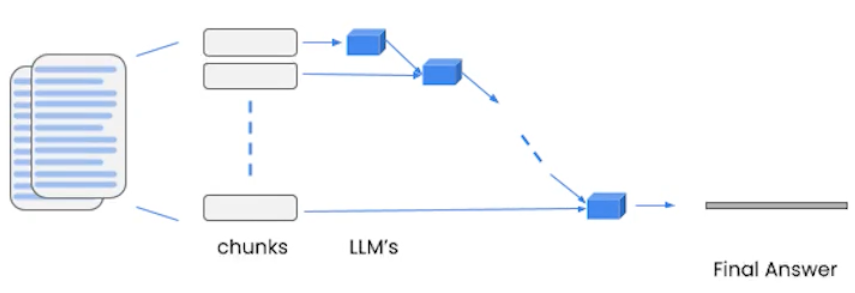

對每個文件加上目前的產出，過一個 LLM Chain 後，產生新的產出，再傳到下一個步驟配合下一篇文章。
- 優點
    - 最終答案是直接而非間接看過每個文章內容得來的
- 缺點
    - 越前面的文章的影響可能越變越小
    - 無法平行化處理

## 5.4 `MapRerankDocumentsChain`
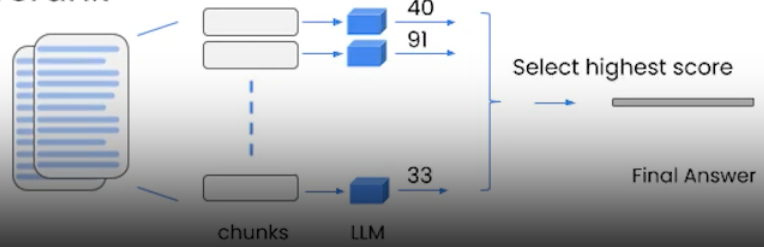

對每個文件的除了產出文字以外還產出評分，然後挑最高的評分的產出
- 優點
    - 適合不是每個文件都重要的情況
- 缺點
    - 沒有辦法結合每個文章的資訊

# 2. 文件順序 （Document Order）
不論是什麼樣的模型，當文件 (document) 合起來的長度很長的時候，研究指出模型會容易忽略靠近中間的資訊。([Lost in the Middle: How Language Models Use Long Contexts](https://arxiv.org/abs/2307.03172)) 而有人指出這個現象可以以人類撰寫的行為解釋，因為人類撰寫長文時，開頭會有整體介紹、結尾會有結論，而學習人類撰寫的文章的語言模型自然會跟著偏重關注頭跟尾。

In [1]:
import langchain_setup
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_transformers import (
    LongContextReorder,
)

# 設定
## 文件 (documents)
texts = [
    "阿姆斯特朗回旋加速噴氣式阿姆斯特朗炮",
    "這麼可愛一定是男孩紙。",
    "如果無法解決問題，就解決提出問題的人。",
    "蟬在叫，人壞掉",
    "不是假髮，是桂！",
]
## 問題
query = "人類的生態?"

# 建立抽取器 (retriever)
retriever = Chroma.from_texts(texts, embedding=OpenAIEmbeddings()).as_retriever(
    search_kwargs={"k": 10}
)

# 抽取相關的文件並依相關度由上到下排序
docs = retriever.get_relevant_documents(query)

docs

[Document(page_content='蟬在叫，人壞掉'),
 Document(page_content='這麼可愛一定是男孩紙。'),
 Document(page_content='如果無法解決問題，就解決提出問題的人。'),
 Document(page_content='不是假髮，是桂！'),
 Document(page_content='阿姆斯特朗回旋加速噴氣式阿姆斯特朗炮')]

而這個問題的其中一個處理方法是，將比較不相關的文件 (document) 放在比較中間，比較相關文件 (document) 放在比較頭尾。

In [2]:
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(docs)

# 確認越相關的文件 (document) 越靠近頭尾
reordered_docs

[Document(page_content='蟬在叫，人壞掉'),
 Document(page_content='如果無法解決問題，就解決提出問題的人。'),
 Document(page_content='阿姆斯特朗回旋加速噴氣式阿姆斯特朗炮'),
 Document(page_content='不是假髮，是桂！'),
 Document(page_content='這麼可愛一定是男孩紙。')]

其底層做法為，從一個空的新序列 (sequence) 開始，每次都從舊的文件 (document) 從抽取最不相關的，放在新序列的頭尾 (頭尾交互放)。詳細可自由參考下列程式碼。

In [3]:
documents = list(docs)  # 不要動到原本的 list
documents.reverse()  # 將順序顛倒，變越不相關越前面
reordered_result = []  # 建立一個空的順序
# 從最不相關的文件開始放，放在頭和放在尾交互做
for i, value in enumerate(documents):
    if i % 2 == 1:
        reordered_result.append(value)
    else:
        reordered_result.insert(0, value)
assert reordered_result == reordered_docs

# 3. (多)文件壓縮 (Documents Compression)

如果給你一整本書讓你回答一個問題，可能光翻書找有相關的地方就已經眼花撩亂，但如果給你重點整理好的一頁文件，你就可以很好地回答這個問題。LLM 也是如此，給它的資訊越長、越雜，它就越有可能無法從中抓到真正需要的資訊來回答。

因此在把所有的抽取出的相關文件合併成一個大文件前，可以先針對各個文件獨立地將跟問題不相關的資訊「剔除」掉，或是將相關的資訊「壓縮」成比較精簡的敘述，來幫助 LLM 更好地去根據提供的資訊回答。

In [1]:
from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Qdrant
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain.retrievers import ContextualCompressionRetriever
from langchain.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import LLMChainExtractor, LLMChainFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.text_splitter import CharacterTextSplitter

from langchain_setup import ChatOpenAI, pprint_documents

documents = [
    Document(page_content="當人員們召喚完後便組成一個幾萬人數的軍團。\n疾疾，護法現身。\n寶具本身是固有結界，將內心的風景具現化，心象的風景是沒有遮蔽物，太陽毒曬以及熱沙亂舞的平原，因為那是亞歷山大的軍隊一同奔騰過的大地，烙印在軍隊全體人員的心目中、令結界得以能夠展開。"),
    Document(page_content="唵嘛呢叭咪吽~ 海公牛!"),  # 跟問題的相關度低的文件
    Document(page_content="死後仍宣誓效忠伊斯坎達爾、與君主一同英靈化的近衛軍團作為Servant降臨於現界。寶具的功能是固有結界，顯現出刻印在亞歷山大的軍隊全體的景象 -- 毒辣的太陽照在一望無際的沙原。"),
]
model = ChatOpenAI(temperature=0)
query = "伊斯坎達爾的寶具，王之軍勢是什麼？"

Langchain 提供了四種現成的作法：
1. `ContextualCompressionRetriever`：將資訊改寫，也可以想成是摘要或重點整理。
2. `LLMChainFilter`: 過濾掉不相關資訊，但保留相關的部分不做改寫。
3. `EmbeddingsFilter`: 直接過濾掉不夠相關的整個文件
4. `EmbeddingsRedundantFilter`: 過濾掉跟其他文件太相似的文件

## 3.1 擷取 (Extraction)
文件中，去除跟問題 (query) 無關的文字，只留下跟問題 (query) 有關的文字

In [2]:
extractor = LLMChainExtractor.from_llm(model)
compressed_documents = extractor.compress_documents(documents, query)
pprint_documents(compressed_documents)
# "\n疾疾，護法現身。\n" 被 LLM 刪掉了

c:\Users\121664\micromamba\envs\dev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\Users\121664\micromamba\envs\dev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\Users\121664\micromamba\envs\dev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

寶具本身是固有結界，將內心的風景具現化，心象的風景是沒有遮蔽物，太陽毒曬以及熱沙亂舞的平原，因為那是亞歷山大的軍隊一同奔騰過的大地，烙印在軍隊全體人員的心目中、令結界得以能夠展開。

Metadata:{}
----------------------------------------------------------------------------------------------------
Document 2:

寶具的功能是固有結界，顯現出刻印在亞歷山大的軍隊全體的景象 -- 毒辣的太陽照在一望無際的沙原。

Metadata:{}


這個功能是靠 prompt engineering 完成的

In [3]:
print(extractor.llm_chain.prompt.template)

Given the following question and context, extract any part of the context *AS IS* that is relevant to answer the question. If none of the context is relevant return NO_OUTPUT. 

Remember, *DO NOT* edit the extracted parts of the context.

> Question: {question}
> Context:
>>>
{context}
>>>
Extracted relevant parts:


## 3.2 過濾不相關文件 by embeddings
以問題 (query) 和文件 (document) 的 embedding 計算相似度，去除相似度太小的文件

In [4]:
embeddings_filter = EmbeddingsFilter(
    embeddings=OpenAIEmbeddings(), similarity_threshold=0.8
)
compressed_documents = embeddings_filter.compress_documents(documents, query)
pprint_documents(compressed_documents)

Document 1:

死後仍宣誓效忠伊斯坎達爾、與君主一同英靈化的近衛軍團作為Servant降臨於現界。寶具的功能是固有結界，顯現出刻印在亞歷山大的軍隊全體的景象 -- 毒辣的太陽照在一望無際的沙原。

Metadata:{}
----------------------------------------------------------------------------------------------------
Document 2:

當人員們召喚完後便組成一個幾萬人數的軍團。
疾疾，護法現身。
寶具本身是固有結界，將內心的風景具現化，心象的風景是沒有遮蔽物，太陽毒曬以及熱沙亂舞的平原，因為那是亞歷山大的軍隊一同奔騰過的大地，烙印在軍隊全體人員的心目中、令結界得以能夠展開。

Metadata:{}


跟抽取器 (retriever) 在演算法設定為相似度閥值 (similarity threshold) 時做的事情大致上是一樣的，只是這個比較單純，也很適合用在文件抽取 (document retrieval) 以外的地方。

## 3.3 過濾不相關文件 by LLM
將問題 (query) 和文件 (document) 直接丟給大型語言模型 (LLM) 決定是否相關

In [5]:
llm_filter = LLMChainFilter.from_llm(model)
compressed_documents = llm_filter.compress_documents(documents, query)
pprint_documents(compressed_documents)

c:\Users\121664\micromamba\envs\dev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\Users\121664\micromamba\envs\dev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\Users\121664\micromamba\envs\dev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

當人員們召喚完後便組成一個幾萬人數的軍團。
疾疾，護法現身。
寶具本身是固有結界，將內心的風景具現化，心象的風景是沒有遮蔽物，太陽毒曬以及熱沙亂舞的平原，因為那是亞歷山大的軍隊一同奔騰過的大地，烙印在軍隊全體人員的心目中、令結界得以能夠展開。

Metadata:{}
----------------------------------------------------------------------------------------------------
Document 2:

死後仍宣誓效忠伊斯坎達爾、與君主一同英靈化的近衛軍團作為Servant降臨於現界。寶具的功能是固有結界，顯現出刻印在亞歷山大的軍隊全體的景象 -- 毒辣的太陽照在一望無際的沙原。

Metadata:{}


這個功能是單靠 prompt engineering 完成的

In [6]:
print(llm_filter.llm_chain.prompt.template)

Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.

> Question: {question}
> Context:
>>>
{context}
>>>
> Relevant (YES / NO):


**想想看**: 利用大型語言模型 (LLM) 來判斷相關程度和利用 embeddings 的相似度來判斷相關程度有什麼差別？各自有什麼優缺點？ 
<details>
<summary>參考</summary>
可參考 Bi-Encoder vs. Cross-Encoder
</details>

## 過濾相似文件
當有數個文件 (document) 提供的資訊差不多時，我們可以留下其中一個就好

In [7]:
redundancy_filter = EmbeddingsRedundantFilter(embeddings=OpenAIEmbeddings(), similarity_threshold=0.8)
filtered_documents = redundancy_filter.transform_documents(documents)
pprint_documents(filtered_documents)

Document 1:

唵嘛呢叭咪吽~ 海公牛!

Metadata:{}
----------------------------------------------------------------------------------------------------
Document 2:

死後仍宣誓效忠伊斯坎達爾、與君主一同英靈化的近衛軍團作為Servant降臨於現界。寶具的功能是固有結界，顯現出刻印在亞歷山大的軍隊全體的景象 -- 毒辣的太陽照在一望無際的沙原。

Metadata:{}


**想想看**: 
- 有沒有可能雖然文件們 (documents) 各自有不同的資訊，但在針對某一個問題 (query) 上能提供的資訊是差不多的？如果有的話我們該怎麼做來過濾掉這些文件？
    <details>
    <summary>參考</summary>
    - 我們可以用大型語言模型 (LLM) 取代 embeddings 來判斷文件 (document) 間是否重複，同時丟給 LLM 待判斷的兩篇文件和問題 (query) ，並用設計的 prompt 來使其比較針對該問題能提供的資訊
    - 可以先把每個文件用 LLM 提取出跟 query 相關的資訊作為新文件，再進行比較
    </details>
- 可以利用大語言模型 (LLM) 取代 embeddings 來做文件間是否冗余的判斷嗎？跟用 embeddings 來講有什麼差異？
    <details>
    <summary>參考</summary>
    可參考 Bi-Encoder vs. Cross-Encoder
    </details>

## 跟抽取器 (retriever) 的連攜技

在文件抽取 (document retrieval) 後執行文件壓縮 (documents compression)

In [8]:
# 文件抽取器 (retriever)
retriever = Qdrant.from_documents(
    documents, embedding=OpenAIEmbeddings(), location=":memory:"
).as_retriever()

# 將文件資訊擷取器 (LLMChainExtractor) 接在抽取器後面
compression_retriever = ContextualCompressionRetriever(
    base_compressor=extractor, base_retriever=retriever
)

# 實際執行看看
retrieved_documents = compression_retriever.get_relevant_documents(query)
pprint_documents(retrieved_documents)

c:\Users\121664\micromamba\envs\dev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\Users\121664\micromamba\envs\dev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\Users\121664\micromamba\envs\dev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>openresty</center>
</body>
</html>
).


還可以跟分割器 (splitter) 和多個不同的壓縮法 (compression) 串連

In [ ]:
# 各種不同的（多）文件處理器 (document transformer)
splitter = CharacterTextSplitter(chunk_size=50, chunk_overlap=0, separator="。")
redundant_filter = EmbeddingsRedundantFilter(embeddings=OpenAIEmbeddings())
relevant_filter = EmbeddingsFilter(
    embeddings=OpenAIEmbeddings(), similarity_threshold=0.8
)

# 串連文件處理器們
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, redundant_filter, relevant_filter]
)

# 接在文件抽取器 (document retriever) 後面
compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline_compressor, base_retriever=retriever
)

# 實際執行看看
retrieved_documents = compression_retriever.get_relevant_documents(query)
pprint_documents(retrieved_documents)

Document 1:

寶具的功能是固有結界，顯現出刻印在亞歷山大的軍隊全體的景象 -- 毒辣的太陽照在一望無際的沙原

Metadata:{}
----------------------------------------------------------------------------------------------------
Document 2:

寶具本身是固有結界，將內心的風景具現化，心象的風景是沒有遮蔽物，太陽毒曬以及熱沙亂舞的平原，因為那是亞歷山大的軍隊一同奔騰過的大地，烙印在軍隊全體人員的心目中、令結界得以能夠展開

Metadata:{}
----------------------------------------------------------------------------------------------------
Document 3:

死後仍宣誓效忠伊斯坎達爾、與君主一同英靈化的近衛軍團作為Servant降臨於現界

Metadata:{}
